# Flight Delay Analytics με Apache Spark

Ονοματεπώνυμο 1: Συμεών Αλμανίδης (ics23083)

Ονοματεπώνυμο 2: Ευστράτιος Μαυρίγκος (ics23117)

# Θέμα 1: Spark RDD API

In [ ]:
from google.colab import files

print("Please upload the CSV file (e.g., flights_2000.csv) when prompted.")
flights_csv = files.upload()

Please upload the CSV file (e.g., flights_2000.csv) when prompted.


Saving flights_2000.csv to flights_2000.csv


In [ ]:
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, desc

spark = SparkSession \
    .builder \
    .getOrCreate()

path = next(iter(flights_csv))


In [ ]:
def time_benchmarking(func):
    print("Starting benchmarking...")
    time_pairs = [func() for _ in range(5)]
    total_times, first_action_times = map(list, zip(*time_pairs))
    # remove min and max and calculate the average
    total_times.sort()
    first_action_times.sort()
    total_times = total_times[1:-1]
    first_action_times = first_action_times[1:-1]
    avg_total_time = sum(total_times) / len(total_times)
    avg_first_action_time = sum(first_action_times) / len(first_action_times)
    print("---------------------------------")
    print(f"Μέσος συνολικός Χρόνος Εκτέλεσης (Total Time): {avg_total_time:.4f} δευτ.")
    print(f"Μέσος χρόνος Υπολογισμού (Action Time): {avg_first_action_time:.4f} δευτ.")
    print("---------------------------------")


In [ ]:
parsed_data_rdd = spark.read.options(inferSchema=True, header=True).csv(path).rdd

def run_flight_delay_analysis():
    start_time = time.time()

    airport_delay_pairs = parsed_data_rdd \
                          .map(lambda row: (row['ORIGIN_AIRPORT'], row['DEP_DELAY']) )


    airport_average_delays = airport_delay_pairs \
                          .filter(lambda pair: pair[1] != None) \
                          .mapValues(lambda delay: (delay, 1)) \
                          .reduceByKey(lambda acc1, acc2: (acc1[0] + acc2[0], acc1[1] + acc2[1])) \
                          .mapValues(lambda totals: totals[0] / totals[1])
    start_action_time = time.time()
    top_10_airports = airport_average_delays.top(10, key=lambda x: x[1])
    end_time = time.time()

    return (end_time - start_time, end_time - start_action_time)
time_benchmarking(run_flight_delay_analysis)

Starting benchmarking...
---------------------------------
Μέσος συνολικός Χρόνος Εκτέλεσης (Total Time): 0.2810 δευτ.
Μέσος χρόνος Υπολογισμού (Action Time): 0.2677 δευτ.
---------------------------------


# Θέμα 2: Spark DataFrame API

In [ ]:
df = spark.read.options(inferSchema=True, header=True).csv(path)
df.printSchema()

def run_flight_analysis():
    start_time = time.time()

    filtered_flights = df \
                  .filter(col("CANCELLED") == 0) \
                  .na.drop(subset=["DEP_DELAY", "ORIGIN_AIRPORT", "DEST_AIRPORT"])

    avg_delay_by_route = filtered_flights \
                  .groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT") \
                  .agg(avg("DEP_DELAY") \
                  .alias("AVG_DELAY")) \
                  .orderBy(desc("AVG_DELAY"))

    start_action_time = time.time()
    top_10_routes = avg_delay_by_route.take(10)
    end_time = time.time()

    top_10_df = spark.createDataFrame(top_10_routes)
    top_10_df.coalesce(1) \
                  .write \
                  .mode("overwrite") \
                  .option("header", "true") \
                  .csv("out/top10.csv")

    return (end_time - start_time, end_time - start_action_time)
time_benchmarking(run_flight_analysis)

root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)

Starting benchmarking...
---------------------------------
Μέσος συνολικός Χρόνος Εκτέλεσης (Total Time): 0.2004 δευτ.
Μέσος χρόνος Υπολογισμού (Action Time): 0.1681 δευτ.
---------------------------------


# Θέμα 4: Οπτικοποίηση & Ανάλυση

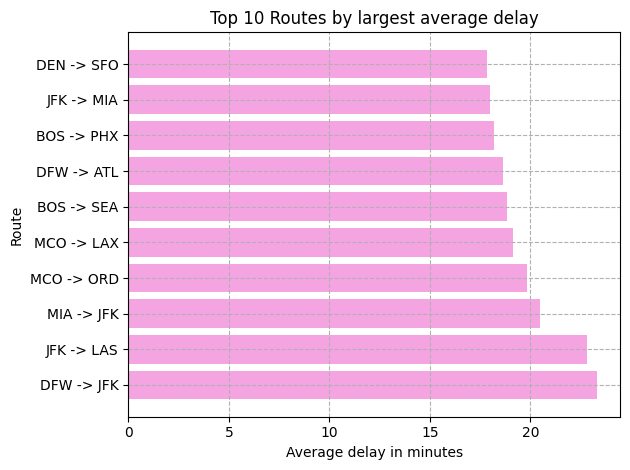

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

path = "out/top10.csv"
all_files = glob.glob(path + "/part-*.csv")

in_df = pd.read_csv(all_files[0])
in_df['ROUTE'] = in_df['ORIGIN_AIRPORT'] + ' -> ' + in_df['DEST_AIRPORT']

plt.barh(in_df['ROUTE'], in_df['AVG_DELAY'], color='#F5A4E2')
plt.title("Top 10 Routes by largest average delay")
plt.xlabel("Average delay in minutes")
plt.ylabel("Route")
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.savefig("Graph4_Top10RoutesByDelay.png", dpi=150)
plt.show()



# Θέμα 5: Επέκταση / Εμπλουτισμός Ανάλυσης

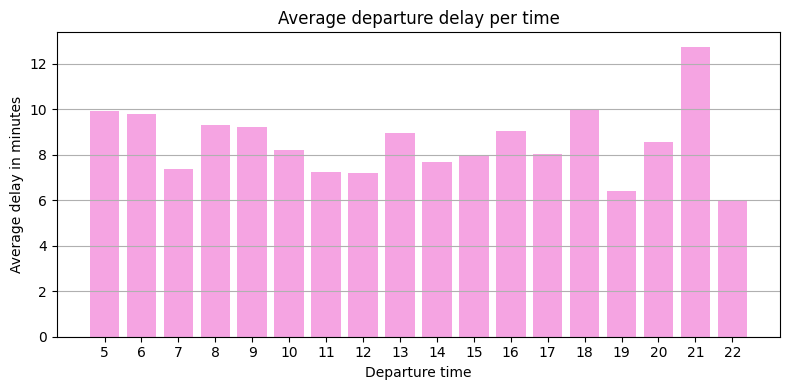

In [ ]:
df_filtered = df.filter(df["CANCELLED"] == 0).na.drop(subset=["DEP_DELAY"])
df_hour = df_filtered.withColumn("HOUR", (col("SCHED_DEP").substr(12, 2)).cast("int"))
avg_delay_by_hour = df_hour \
                .groupBy("HOUR") \
                .agg(avg("DEP_DELAY") \
                .alias("AVG_DELAY"))\
                .orderBy("HOUR")
pd_avg = avg_delay_by_hour.toPandas() \
                .dropna(subset=['HOUR']) \
                .sort_values(by="HOUR")
plt.figure(figsize=(8, 4))
plt.bar(pd_avg['HOUR'], pd_avg['AVG_DELAY'], color='#F5A4E2')
plt.title("Average departure delay per time")
plt.xlabel("Departure time")
plt.ylabel("Average delay in minutes")
plt.xticks(range(int(pd_avg['HOUR'].min()), int(pd_avg['HOUR'].max()+1)))
plt.grid(True, linestyle='-', axis='y')
plt.tight_layout()
plt.savefig("Graph5a_AvgDelayPerTime.png", dpi=150)
plt.show()

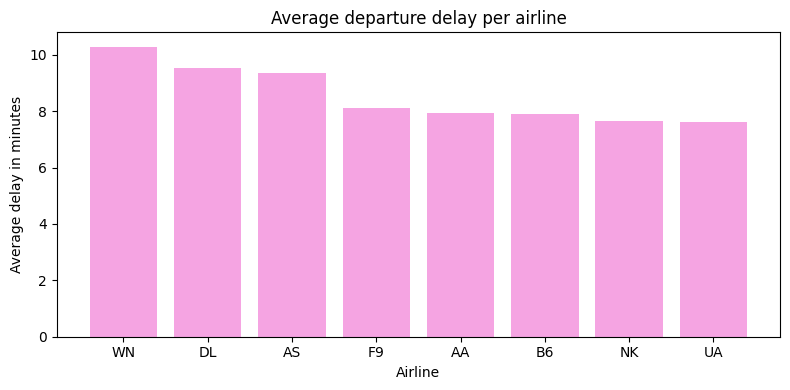

In [ ]:
airline_filtered_df = df \
        .groupBy("AIRLINE") \
        .agg(avg("DEP_DELAY").alias("AVG_DEP_DELAY")) \
        .orderBy(desc("AVG_DEP_DELAY"))

airline_pdf = airline_filtered_df.toPandas()

plt.figure(figsize=(8, 4))
plt.bar(airline_pdf["AIRLINE"], airline_pdf["AVG_DEP_DELAY"], color='#F5A4E2')
plt.xlabel("Airline")
plt.ylabel("Average delay in minutes")
plt.title("Average departure delay per airline")
plt.tight_layout()
plt.savefig("Graph5b_AvgDelayPerAirline.png", dpi=150)
plt.show()

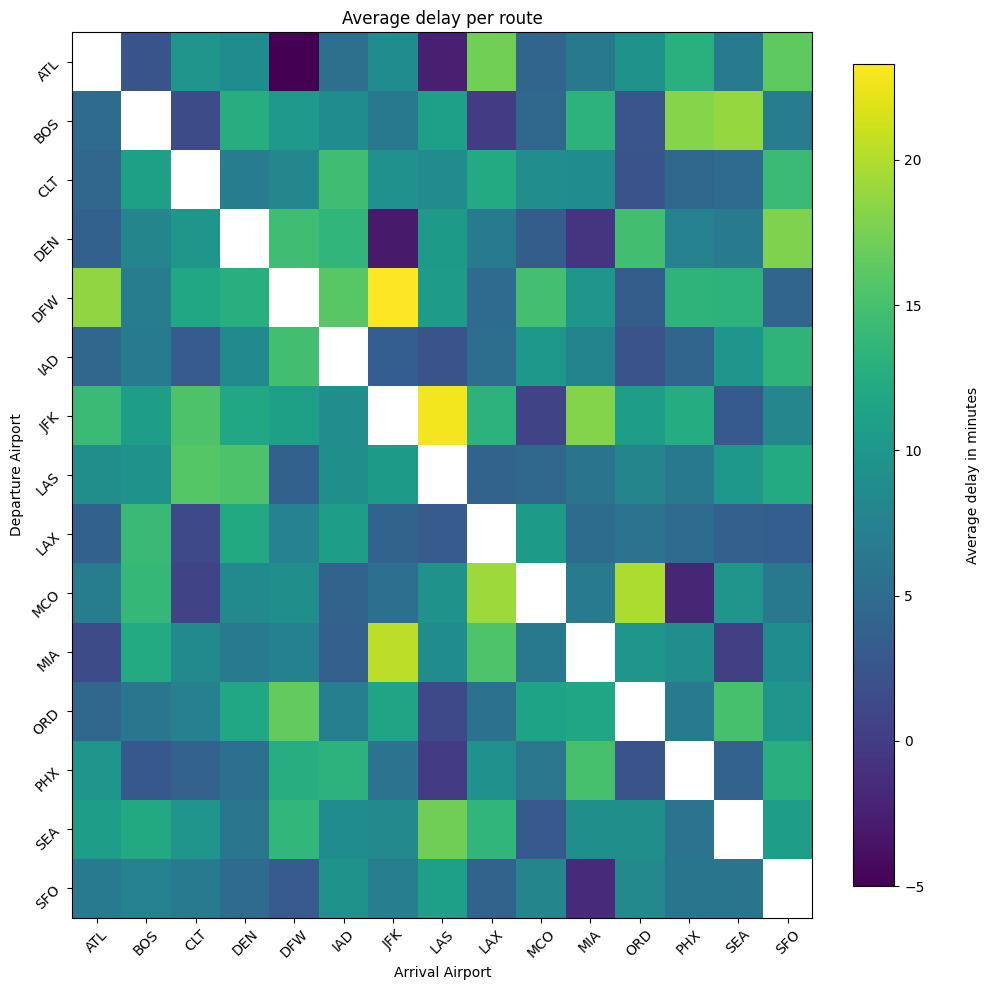

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

heatmap_df = df \
    .groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT") \
    .agg(avg("DEP_DELAY") \
    .alias("AVG_DELAY")) \
    .orderBy(desc("AVG_DELAY"))

pd_heatmap = heatmap_df.toPandas()

heatmap_data = pd_heatmap.pivot(
    index="ORIGIN_AIRPORT",
    columns="DEST_AIRPORT",
    values="AVG_DELAY"
)

plt.figure(figsize=(10, 10))
im = plt.imshow(heatmap_data, cmap="viridis", aspect="auto")

cbar = plt.colorbar(im, fraction=0.050, pad=0.05)
cbar.set_label("Average delay in minutes", labelpad=30)

plt.xticks(range(len(heatmap_data.columns)), heatmap_data.columns, rotation=45, fontsize=10)
plt.yticks(range(len(heatmap_data.index)), heatmap_data.index, rotation=45, fontsize=10)
plt.xlabel("Arrival Airport")
plt.ylabel("Departure Airport")
plt.title("Average delay per route")
plt.savefig("Graph5c_AvgDelayPerRoute.png", dpi=150)
plt.tight_layout()
plt.show()